In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import textdistance
import tqdm
import seaborn as sns
import selfies as sf
import matplotlib.pyplot as plt
import matplotlib

In [2]:
class CONFIGS:
    def __init__(self):
        self.NUM_IDX = 5

        self.INPUT_DIR = {
            'stoned':os.path.join('/Data1', 'sungmin', 'stoned-selfies', 'data'),
            'selfedit':os.path.join('/Data1', 'sungmin', 'fairseq', 'fairseq_cli', 'result', 'outputs_1_evaluate_property_similarity_scores')
        }
        self.OUTPUT_DIR = 'outputs_3_draw_selfies_collapse'
        if not os.path.exists(self.OUTPUT_DIR):
            os.mkdir(self.OUTPUT_DIR)
    
configs = CONFIGS()

## Generated molecules

In [3]:
df_stoned_qed = pd.read_pickle(os.path.join(configs.INPUT_DIR['stoned'], 'stoned_{}_top_sel.pkl'.format('qed'))).reset_index(drop=True)
df_stoned_drd2 = pd.read_pickle(os.path.join(configs.INPUT_DIR['stoned'], 'stoned_{}_top_sel.pkl'.format('drd2'))).reset_index(drop=True)

In [4]:
df_selfedit_qed = pd.read_csv(os.path.join(configs.INPUT_DIR['selfedit'], 'qed', 'generated_edit_iter{}.csv'.format(1)))
df_selfedit_drd2 = pd.read_csv(os.path.join(configs.INPUT_DIR['selfedit'], 'drd2', 'generated_edit_iter{}.csv'.format(2)))

In [5]:
selfies_ctrl_qed = df_stoned_qed.loc[:,'selfies'].values.tolist()
selfies_ctrl_drd2 = df_stoned_drd2.loc[:,'selfies'].values.tolist()

In [6]:
selfies_test_qed = df_selfedit_qed.loc[:,'SELFIES_opt'].values.tolist()
selfies_test_drd2 = df_selfedit_drd2.loc[:,'SELFIES_opt'].values.tolist()

## Levenshtein distance 

In [7]:
def calc_lev_score(sel):
    rec = sf.encoder(sf.decoder(sel))
    
    sel_tokens = list(sf.split_selfies(sel))
    rec_tokens = list(sf.split_selfies(rec))
    
    return textdistance.levenshtein.distance(sel_tokens, rec_tokens)

In [8]:
def make_lev_dataframe(selfies_ctrl, selfies_test, labels={'ctrl':'STONED', 'test':'SELF-EdiT'}):
    df_ctrl = pd.Series(selfies_ctrl, name='SELFIES').to_frame()
    for i in tqdm.trange(len(df_ctrl)):
        df_ctrl.loc[i,'Levenshtein Distance'] = calc_lev_score(df_ctrl.loc[i,'SELFIES'])
        df_ctrl.loc[i,'Levenshtein Distance'] = df_ctrl.loc[i,'Levenshtein Distance'].astype(int)
    df_ctrl.loc[:,'Collapse rates'] = f"{labels['ctrl']} ({(df_ctrl.loc[:,'Levenshtein Distance'] > 0).value_counts()[True] / len(df_ctrl):.3f})"
    
    df_test = pd.Series(selfies_test, name='SELFIES').to_frame()
    for i in tqdm.trange(len(df_test)):
        df_test.loc[i,'Levenshtein Distance'] = calc_lev_score(df_test.loc[i,'SELFIES'])
        df_test.loc[i,'Levenshtein Distance'] = df_test.loc[i,'Levenshtein Distance'].astype(int)
    df_test.loc[:,'Collapse rates'] = f"{labels['test']} ({(df_test.loc[:,'Levenshtein Distance'] > 0).value_counts()[True] / len(df_test):.3f})"
    
    return pd.concat((df_test, df_ctrl), ignore_index=True) 

In [9]:
df_qed = make_lev_dataframe(selfies_ctrl_qed, selfies_test_qed)
df_drd2 = make_lev_dataframe(selfies_ctrl_drd2, selfies_test_drd2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:34<00:00, 577.84it/s]


# Draw plot

In [22]:
df_qed_nonzero = df_qed[(df_qed['Levenshtein Distance'] > 0) & (df_qed['Levenshtein Distance'] < 11)].reset_index(drop=True)
df_drd2_nonzero = df_drd2[(df_drd2['Levenshtein Distance'] > 0) & (df_drd2['Levenshtein Distance'] < 11)].reset_index(drop=True)

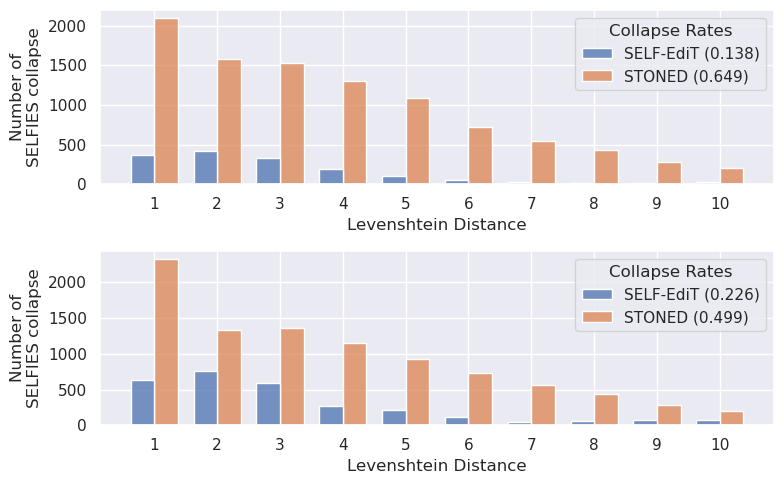

In [26]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(2,1,figsize=(8,5))

_ = sns.histplot(
    data=df_qed_nonzero,
    x='Levenshtein Distance',
    hue='Collapse Rates',
    discrete=True,
    multiple='dodge',
    shrink=0.75,
    ax=ax[0],
)

_ = sns.histplot(
    data=df_drd2_nonzero,
    x='Levenshtein Distance',
    hue='Collapse Rates',
    discrete=True,
    multiple='dodge',
    shrink=0.75,
    ax=ax[1],
)

for i in range(2):
    ax[i].set_xticks(range(1,11))
    ax[i].set_ylabel('Number of\nSELFIES collapse')

plt.tight_layout()
#plt.show()
plt.savefig(os.path.join(configs.OUTPUT_DIR, 'histplots_qed_drd2.png'), dpi=300)